# Cell-type specific GRNs inference from PBMCs

## Step 1. Import packages

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import itertools


Bad key "text.kerning_factor" on line 4 in
/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Set matplotlib setting

In [2]:
plt.rc('font', family = "Times New Roman")
my_colors = ["#1EB2A6","#ffc4a3","#e2979c","#F67575"]
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')# 设置输出图像格式

## Step 2. Read and preprocess the scRNA-seq data from PBMCs

In [4]:
adata = sc.read_10x_mtx("/home/wangjiacheng/MyGRN/Datasets/PBMC/filtered_gene_bc_matrices/GRCh38/", var_names='gene_symbols', cache=True)
adata.var_names_make_unique()
adata
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells=3)

... writing an h5ad cache file to speedup reading next time


/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:891: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "var")
/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:868: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "obs")


### Calculate the proportion of mitochondrial genes to all genes

/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"
/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


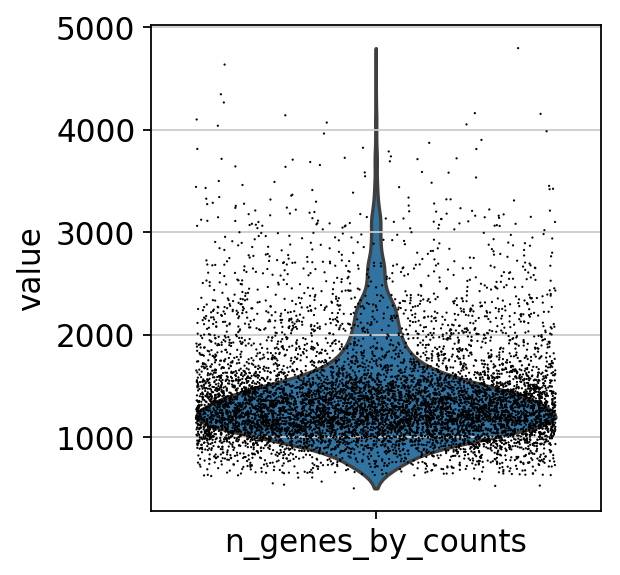

/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"
/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


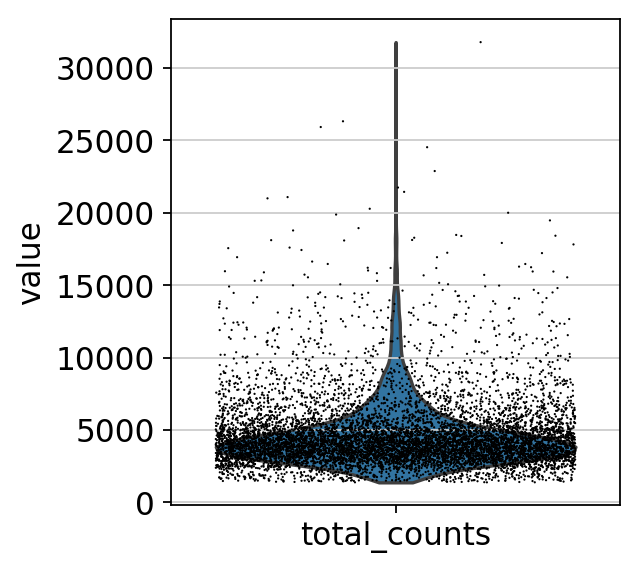

/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"
/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


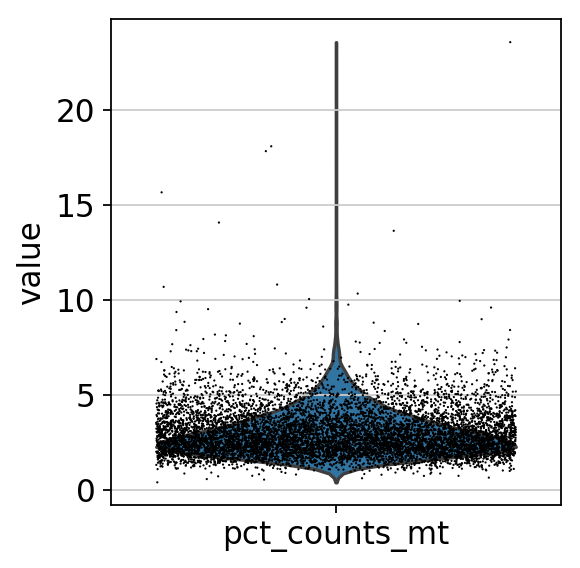

In [11]:
adata.var_names[adata.var_names.str.match(r'^MT-')]
adata.var_names[adata.var_names.str.match(r'RP[SL0-9]')]
adata.var_names[adata.var_names.str.match(r'^ERCC-')]
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4)
sc.pl.violin(adata, ['total_counts'], jitter=0.4)
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4)

/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


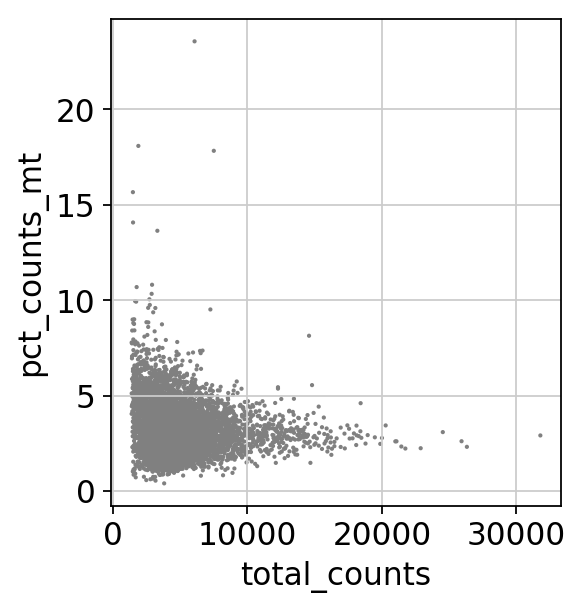

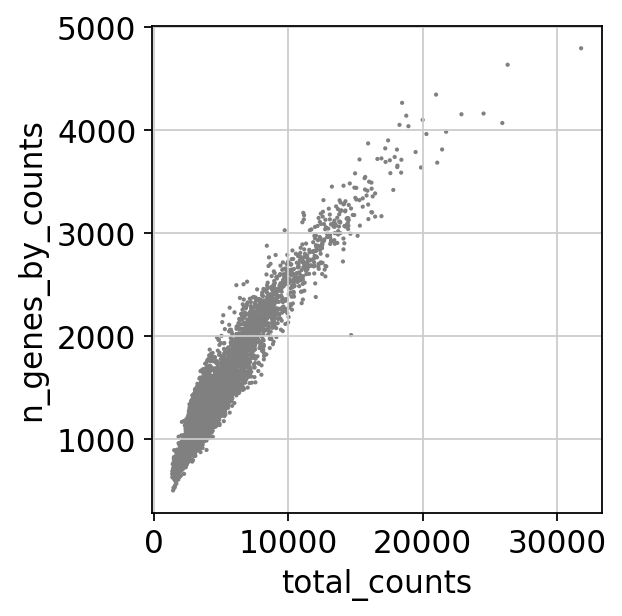

In [12]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt')
sc.pl.scatter(adata, x = 'total_counts', y = 'n_genes_by_counts')

### Filtration

In [13]:
adata = adata[adata.obs.pct_counts_mt < 8, :]
adata = adata[adata.obs.n_genes_by_counts < 4000, :]

### Normalization

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp = 0.5)
sc.pl.highly_variable_genes(adata)

/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


### Perfrom PCA to reduce the dimension using highly variable genes

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


    finished (0:00:13)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


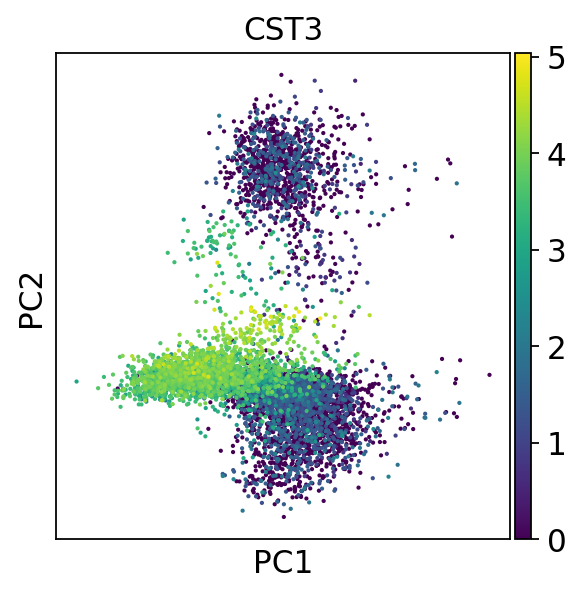

/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


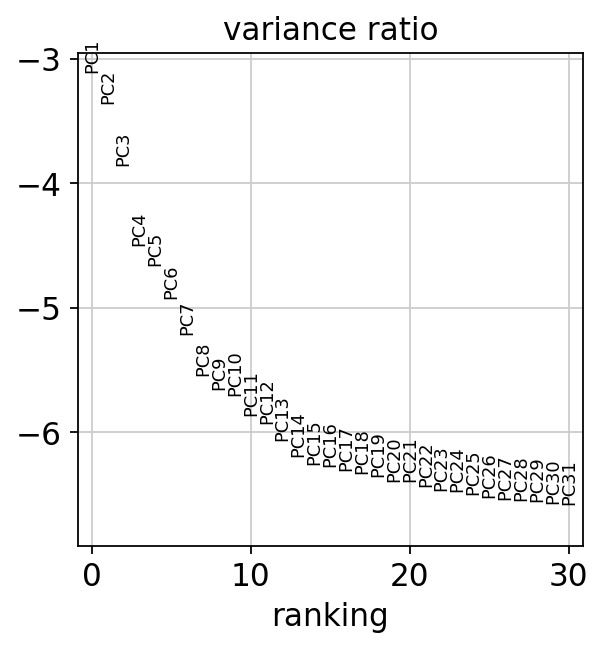

In [17]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color = 'CST3')
sc.pl.pca_variance_ratio(adata, log = True)

## Step 3. Clustering analysis by leiden and visualization by TSNE

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:23)


/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


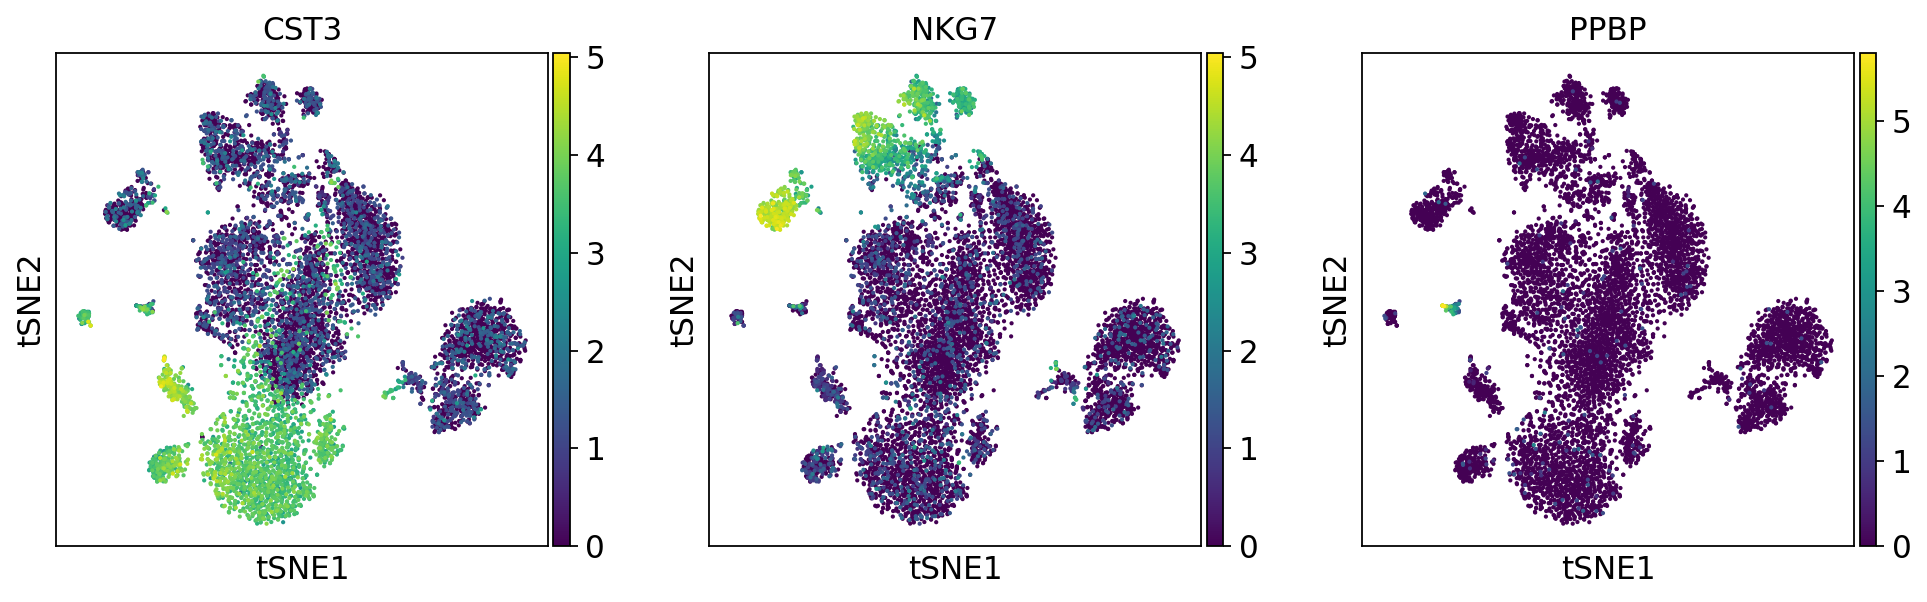

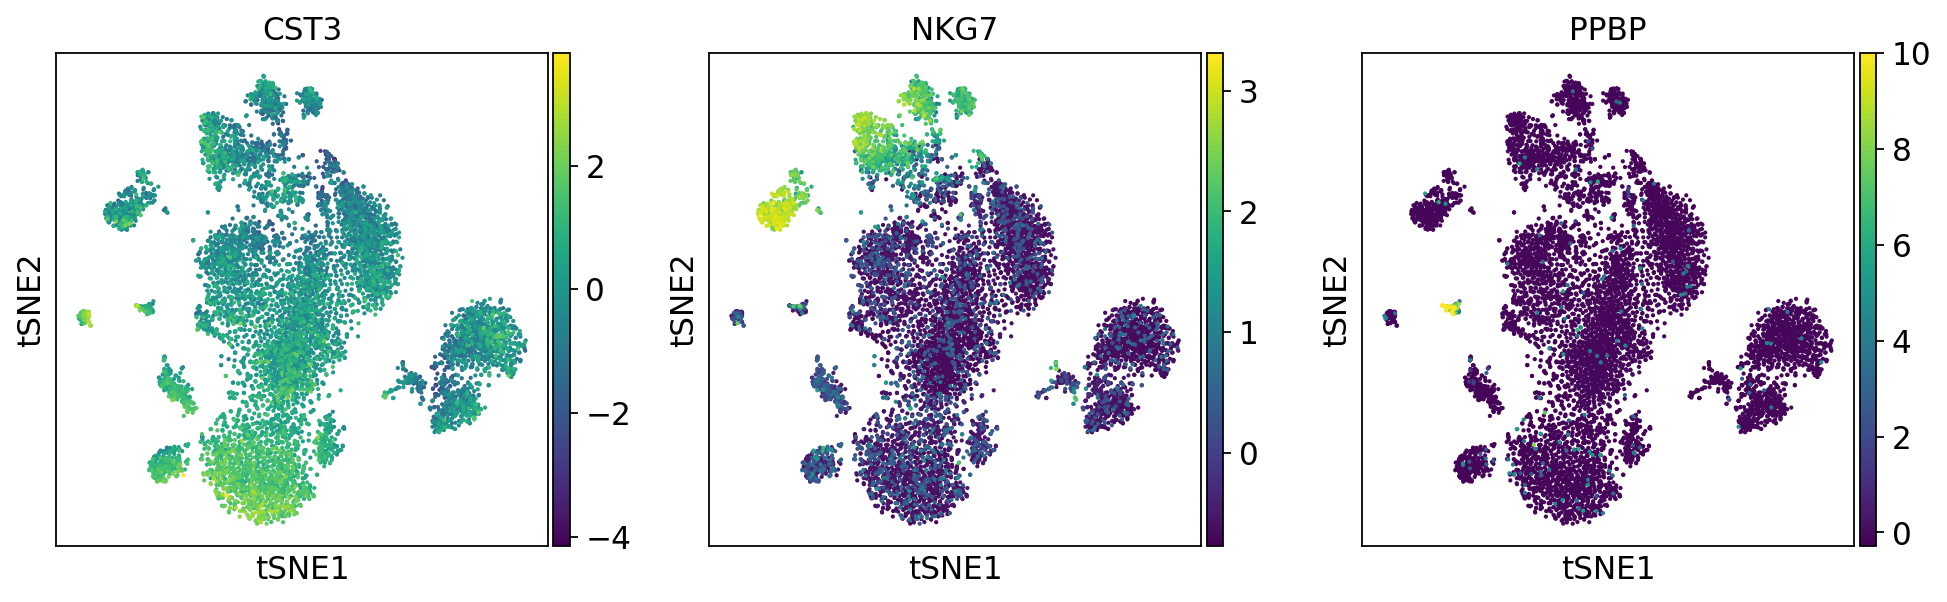

In [19]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.tsne(adata)
sc.pl.tsne(adata, color = ['CST3', 'NKG7', 'PPBP'])
sc.pl.tsne(adata, color = ['CST3', 'NKG7', 'PPBP'], use_raw=False)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


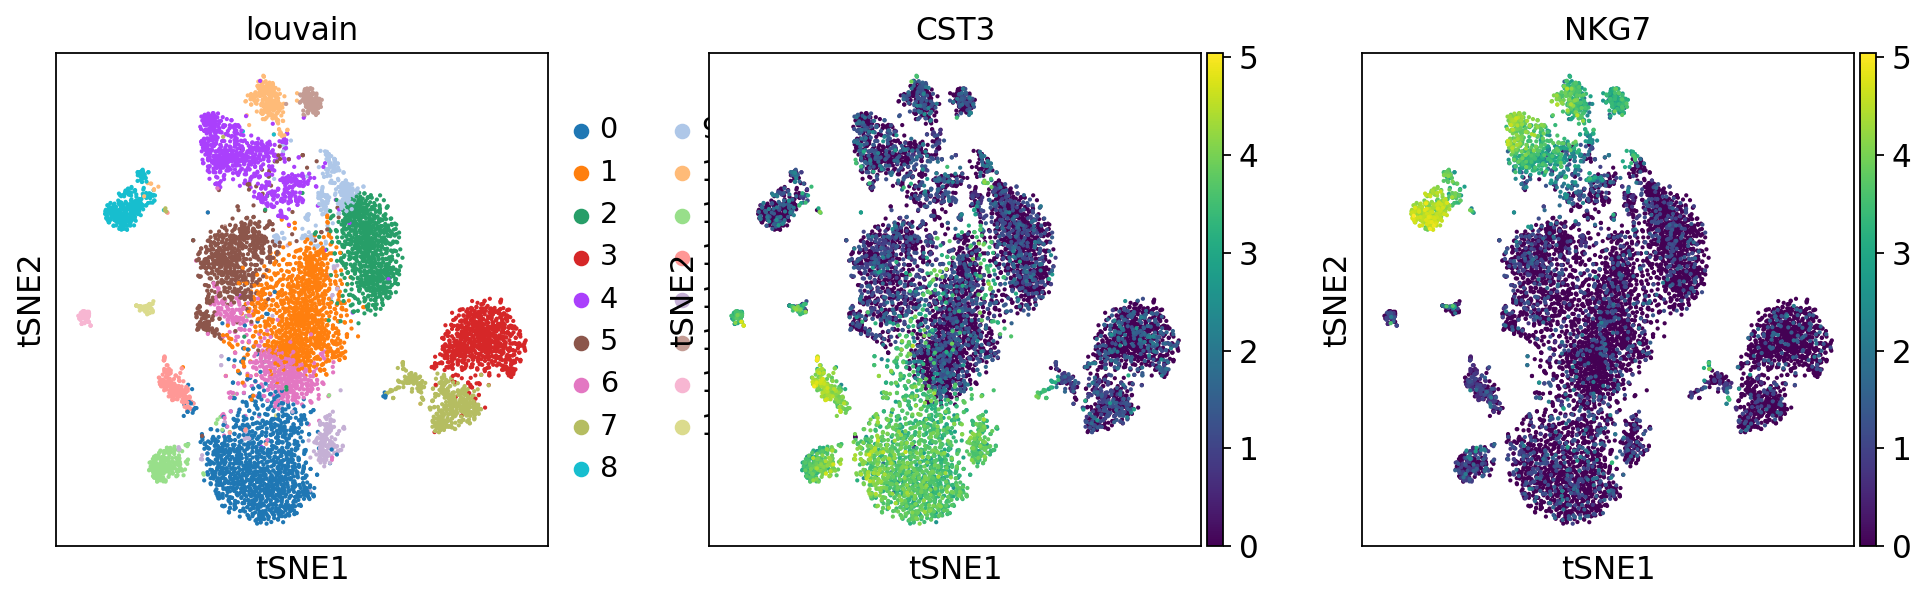

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)
sc.pl.tsne(adata, color = 'leiden')

### Find marker genes for cell population annotation

ranking genes


/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


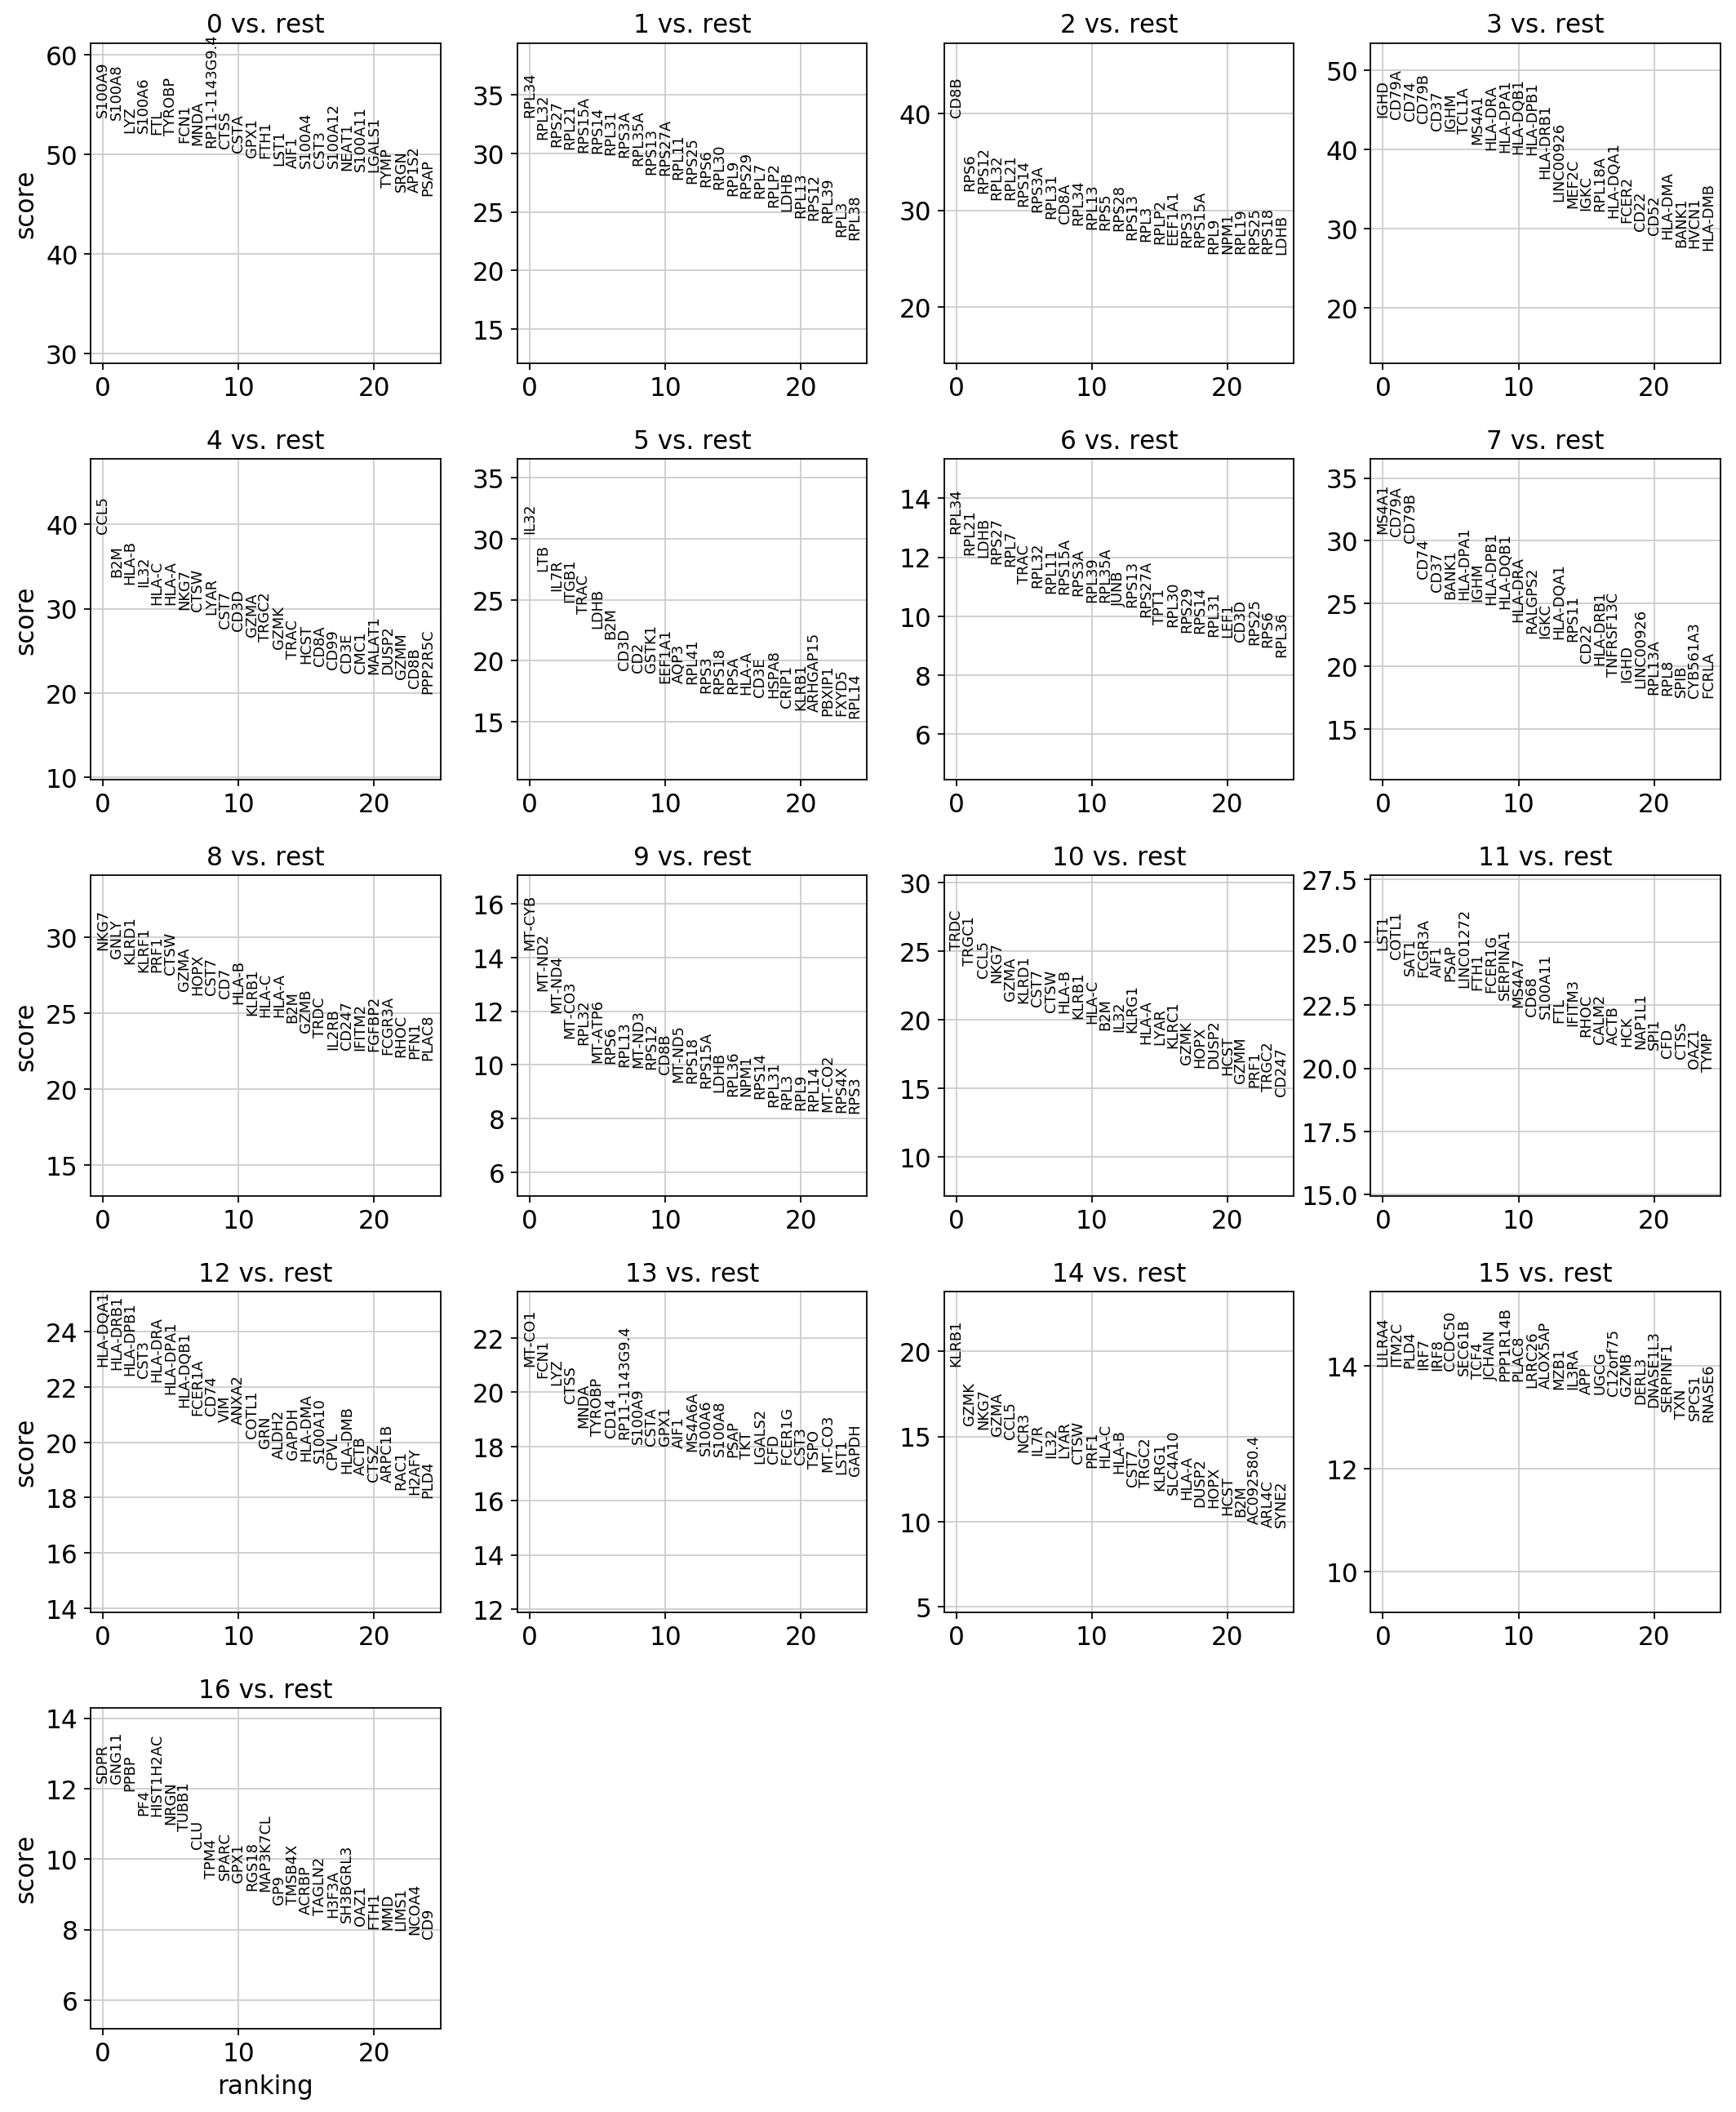

In [26]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [29]:
num = 2
marker_genes = list(set(np.array(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(num)).reshape(-1)))
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '-' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).iloc[0:6, 0:6]

32

In [40]:
result_file = '/home/wangjiacheng/MyGRN/Datasets/PBMC/write/pbmc8k.h5ad'

In [42]:
adata.write(result_file)

/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


### Select the top-four cell types with large number of cells

In [76]:
adata.obs['leiden'].value_counts()

0     1501
1     1292
2      979
3      881
4      770
5      767
6      374
7      321
8      273
9      220
10     204
11     201
12     129
13     114
14      89
15      86
16      66
17      55
18      17
Name: leiden, dtype: int64

In [82]:
clus0 = adata[adata.obs['leiden'].isin(['0']),:]
clus0.write('/home/wangjiacheng/MyGRN/Datasets/PBMC/write/CD4T.h5ad')

In [110]:
clus1 = adata[adata.obs['leiden'].isin(['1']), :]
clus1.write('/home/wangjiacheng/MyGRN/Datasets/PBMC/write/CD14Monocyte.h5ad')

In [114]:
clus2 = adata[adata.obs['leiden'].isin(['2']),:]
clus2.write('/home/wangjiacheng/MyGRN/Datasets/PBMC/write/CD8T.h5ad')

/home/wangjiacheng/src/ENTER/envs/scIGANs/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


In [116]:
clus3 = adata[adata.obs['leiden'].isin(['4', '6']),:]
clus3.write('/home/wangjiacheng/MyGRN/Datasets/PBMC/write/BC.h5ad')

## Step 4. Using DeepRIG to perform cell-type specific GRN inference.

In [ ]:
import os
os.chdir(os.getcwd())
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
from train import *
from util.utils import div_list
import time
from evaluate import evaluateAU, evaluateEPR, evaluateAUPRratio

### Read the ground truth

In [ ]:
refNetwork = pd.read_csv('/home/wangjiacheng/MyGRN/Datasets/PBMC/Blood_refNetwork.csv', header = 0)

### Cell-type specific GRNs inferring

In [ ]:
pbmc_4clus = [clus0, clus1, clus2, clus3]
pbmc_4clus_name = ["CD4 T", "CD14 Monocyte", "CD8 T", "B"]
for k in range(4):
    clus = pbmc_4clus[k]
    labels = []
    var_names = list(clus.var_names)
    num_genes = len(var_names)
    AM = np.zeros([num_genes, num_genes])
    for row_index, row in refNetwork.iterrows():
        AM[var_names.index(row[0]), var_names.index(row[1])] = 1
        label_triplet = []
        label_triplet.append(var_names.index(row[0]))
        label_triplet.append(var_names.index(row[1]))
        label_triplet.append(1)
        labels.append(label_triplet)
    labels = np.array(labels)
    
    ##Computing the SPCC from clus
    data = pd.DataFrame(clus.X)
    corr = data.corr(method = 'spearman')
    corr.values[corr.values < 0.0] = 0.0
    adj = np.array(corr.values)
    
    TF = set(refNetwork['Gene1'])
    
    ## 3 Cross-validation
    reorder = np.arange(labels.shape[0])
    np.random.shuffle(reorder)
    cv = 3
    order = div_list(reorder.tolist(), cv)
    
    ## Define the hyperparameters
    flags = tf.flags
    FLAGS = flags.FLAGS
    flags.DEFINE_string('f', '', "kernel")
    flags.DEFINE_string('model', 'DeepRIG', 'Model string.')
    flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
    flags.DEFINE_integer('epochs', 500, 'Number of epochs to train.')
    flags.DEFINE_integer('hidden1', 200, 'Number of units in hidden layer 1.')
    flags.DEFINE_float('dropout', 0.7, 'Dropout rate (1 - keep probability).')
    flags.DEFINE_float('weight_decay', 1e-4, 'Weight for L2 loss on embedding matrix.')
    flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')
    flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
    flags.DEFINE_integer('ratio', 1, 'Ratio of negetive samples to positive samples.')
    flags.DEFINE_integer('dim', 300, 'The size of latent factor vector.')
    
    pred_results = []
    for i in range(cv):
        print("Cross validation:", '%01d' % (i))
        result_path_cv = '/Useless'
        test_arr = order[i]
        arr = list(set(reorder).difference(set(test_arr)))
        np.random.shuffle(arr)
        train_arr = arr
        pred_matrix = train(FLAGS, adj, train_arr, test_arr, labels, AM, var_names, TF, result_path_cv)
        pred_results.append(pred_matrix)
    output = pred_results[0]
    for j in range(1, 3):
        output = pd.concat([output, pred_results[j]])
    output['EdgeWeight'] = abs(output['EdgeWeight'])
    output.groupby(['Gene1', 'Gene2']).mean()
    output.to_csv('/home/wangjiacheng/MyGRN/Datasets/PBMC/results/Inferred_GRNs_' + pbmc_4clus_name[k] + '.csv', header = True, index = False)